# Exploratory Data Analysis

In [1]:
import pandas as pd
import os
import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# activate matplotlib and set style
% matplotlib inline
plt.style.use('ggplot')

In [3]:
# path to short element json file
short_elements_dir = os.path.join(os.pardir,'data', 'interim', 'short_elements.json')

In [4]:
# decode json file
with open(short_elements_dir, encoding='utf-8') as f:
    d = json.load(f)

In [5]:
# retrieve institution information
df_institution = json_normalize(d, record_path='Institution', meta=['award_id', 'amount', 'eff_date'])

In [6]:
df_institution.head(10)

,City,Country,Name,State,StreetAddress,eff_date,award_id,amount
0,BERKELEY,United States,University of California-Berkeley,CA,Sponsored Projects Office,04/15/1960,6000001,125000
1,Washington,United States,The Geochemical Society,DC,Carnegie Institution for Science,12/15/1961,6100002,28000
2,BLACKSBURG,United States,Virginia Polytechnic Institute and State Unive...,VA,Sponsored Programs 0170,12/15/1961,6100003,40160
3,WASHINGTON,United States,American Association For Advancement Science,DC,"1200 NEW YORK AVENUE, N.W.",02/15/1962,6100004,
4,ARLINGTON,United States,American Anthropological Assoc,VA,"2300 Clarendon Blvd, Suite 1301",02/15/1962,6100005,1334824
5,Troy,United States,Rensselaer Polytechnic Institute,NY,110 8TH ST,06/09/1961,6100006,169800
6,Cambridge,United States,Massachusetts Institute of Technology,MA,77 MASSACHUSETTS AVE,03/15/1961,6100100,198000
7,Washington,United States,National Academy of Sciences,DC,500 FIFTH STREET NW,02/15/1963,6200002,0
8,HONOLULU,United States,University of Hawaii,HI,"2440 Campus Road, Box 368",09/24/1962,6200003,23875
9,Washington,United States,American Geophysical Union,DC,2000 FLORIDA AVE NW,10/15/1962,6200005,0


### Deal with missing data

In [7]:
df_institution.amount.replace('', pd.np.nan, inplace = True)

In [8]:
# convert amount to numeric before setting 0 to nan
df_institution.amount = df_institution.amount.astype('float64')
df_institution.loc[df_institution.amount == 0, 'amount'] = pd.np.nan

In [9]:
df_institution.Name.replace('', pd.np.nan, inplace = True)

In [10]:
df_institution.eff_date = pd.to_datetime(df_institution.eff_date, format='%m/%d/%Y')
# df_institution.set_index('eff_date', inplace = True)

In [11]:
df_institution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438574 entries, 0 to 438573
Data columns (total 8 columns):
City             438574 non-null object
Country          438574 non-null object
Name             438573 non-null object
State            438574 non-null object
StreetAddress    438574 non-null object
eff_date         438574 non-null datetime64[ns]
award_id         438574 non-null int32
amount           435528 non-null float64
dtypes: datetime64[ns](1), float64(1), int32(1), object(5)
memory usage: 25.1+ MB


In [12]:
df_institution.head()

,City,Country,Name,State,StreetAddress,eff_date,award_id,amount
0,BERKELEY,United States,University of California-Berkeley,CA,Sponsored Projects Office,1960-04-15,6000001,125000.0
1,Washington,United States,The Geochemical Society,DC,Carnegie Institution for Science,1961-12-15,6100002,28000.0
2,BLACKSBURG,United States,Virginia Polytechnic Institute and State Unive...,VA,Sponsored Programs 0170,1961-12-15,6100003,40160.0
3,WASHINGTON,United States,American Association For Advancement Science,DC,"1200 NEW YORK AVENUE, N.W.",1962-02-15,6100004,NaN
4,ARLINGTON,United States,American Anthropological Assoc,VA,"2300 Clarendon Blvd, Suite 1301",1962-02-15,6100005,1334824.0


### Take a look at institutions

In [13]:
df_count = df_institution[df_institution.amount.notnull()].groupby('Name').amount.agg(['sum', 'count'])

In [14]:
df_count.rename(columns={'sum' : 'total_amount', 'count': 'num_grant'}, inplace=True)

In [15]:
df_count.head()

,total_amount,num_grant
Name,,
DATA NOT AVAILABLE,215000.0,1
18F GSA,1509064.0,4
21st Century School Fund,426044.0,2
27 International Geographical Congress,883860.0,2
2Cimple Inc,737305.0,2


In [16]:
# normalize to billions of dollars
df_count.total_amount = df_count.total_amount/1e9

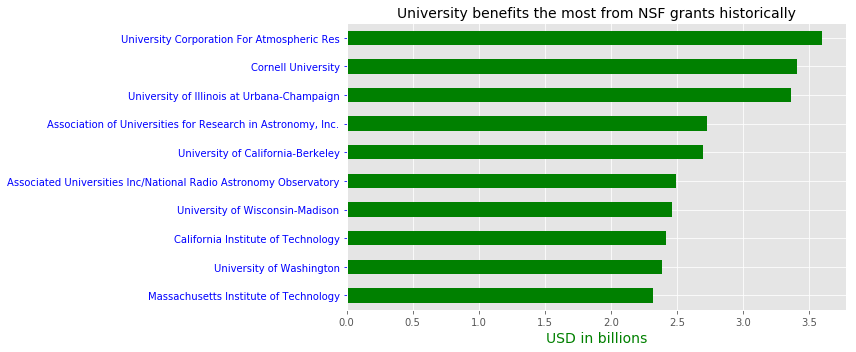

In [17]:
fig , ax = plt.subplots(figsize = (12, 5))
df_count.sort_values('total_amount', ascending=False).head(10).total_amount.plot.barh(ax=ax, color='g')
ax.invert_yaxis()
ax.set_xlabel('USD in billions', color='g', fontsize = 14)
ax.tick_params(axis = 'y', colors = 'b')
ax.set_ylabel('')
_= ax.set_title('University benefits the most from NSF grants historically', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(os.pardir, 'img', 'TotalAmount.png'))

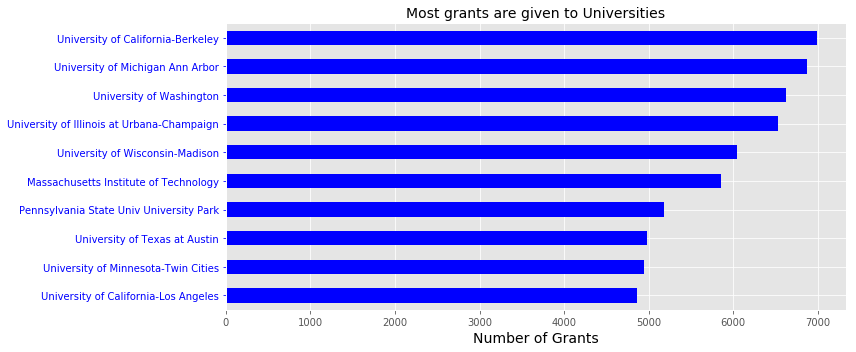

In [18]:
fig2 , ax2 = plt.subplots(figsize = (12, 5))
df_count.sort_values('num_grant', ascending=False).head(10).num_grant.plot.barh(ax=ax2, color='b')
ax2.invert_yaxis()
ax2.set_xlabel('Number of Grants', color='k', fontsize = 14)
ax2.tick_params(axis = 'y', colors = 'b')
ax2.set_ylabel('')
_= ax2.set_title('Most grants are given to Universities', fontsize=14)
plt.tight_layout()
fig2.savefig(os.path.join(os.pardir, 'img', 'Number0fgrants.png'))

### A closer look at U of M and Cornell

In [26]:
# keep Michigan and Cornell
crit = df_institution.Name.isin(['University of Michigan Ann Arbor', 'Cornell University'])
df_spe = df_institution.loc[ crit ,['eff_date', 'amount', 'Name']]
df_spe.head()

,eff_date,amount,Name
95,1967-05-15,42000.0,University of Michigan Ann Arbor
112,1967-11-27,60317912.0,Cornell University
301,1970-09-01,326600.0,University of Michigan Ann Arbor
377,1969-05-01,35000.0,Cornell University
382,1969-07-01,140000.0,Cornell University


In [27]:
# filter out of range date 
df_spe = df_spe[df_spe.eff_date > '1900-01-01']

In [28]:
# same date appears multiple times, groupby date and Name
df_spe = df_spe.groupby(['eff_date', 'Name']).agg('sum')

In [29]:
# amount received per date and per university
df_spe = df_spe.unstack().dropna()
df_spe.head()

amount                                 
Name       Cornell University University of Michigan Ann Arbor
eff_date                                                      
1969-11-26           414467.0                         440612.0
1970-09-01            32200.0                         439200.0
1971-06-01           280000.0                        3100000.0
1971-06-15           246300.0                         309150.0
1972-01-01           228000.0                         213800.0

In [34]:
# take the cumulative sum
df_spe = df_spe.cumsum()

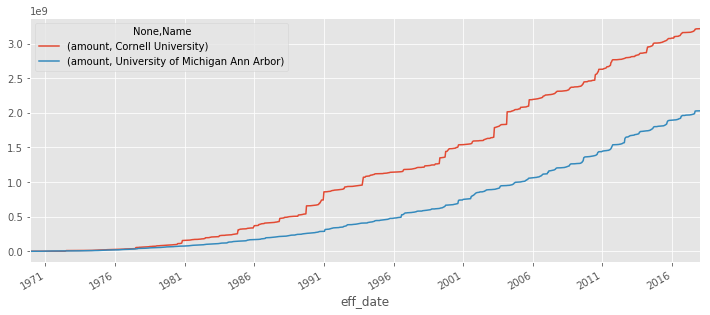

In [36]:
fig3 , ax3 = plt.subplots(figsize = (12, 5))
_ = df_spe.plot.line(ax=ax3)